This dataset has 4288 rows and 14 columns.

### Proporção de Classes em Treino ###
Porcentagem Classe 'IEDB_Tryp': 53.51549483505498%
Porcentagem Classe 'UNIPROT_RANDOM': 46.48450516494502%

### Proporção de Classes em Teste ###
Porcentagem Classe 'IEDB_Tryp': 53.535353535353536%
Porcentagem Classe 'UNIPROT_RANDOM': 46.464646464646464%

Feature importance
KarplusSchulz: 56.16%
Emini: 13.53%
Kolaskar: 7.13%
Parker: 5.64%
ChouFosman: 3.66%
Hydropathy: 3.24%
IP: 3.09%
MW: 2.90%
Ending_Position: 1.69%
Starting_Position: 1.52%
Bepipred3: 1.44%


<ipython-input-7-ae24fe70b92f>:120: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')  # Converter para número quando possível


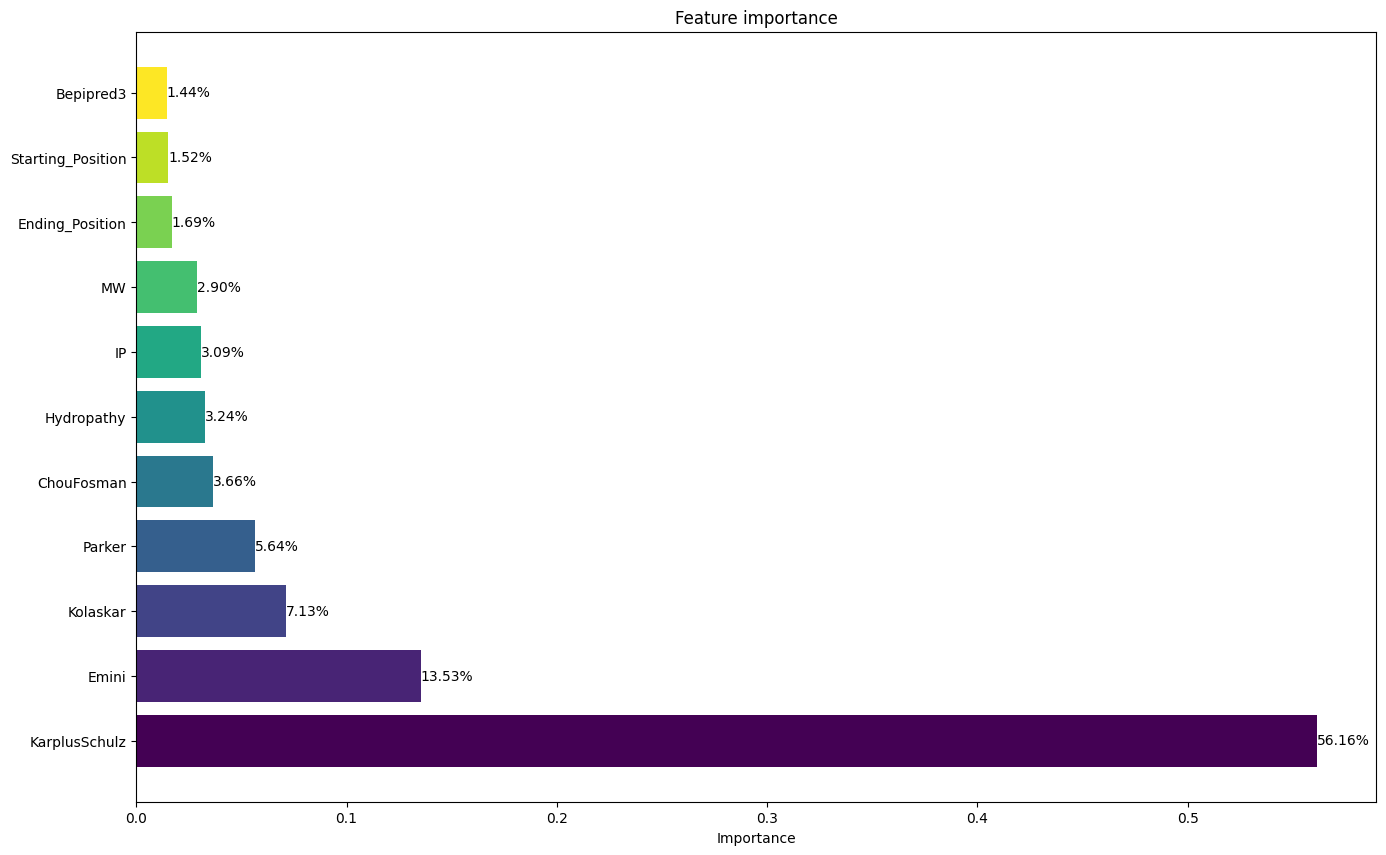


### Métricas para Test ###
Acurácia: 0.9036519036519036
Recall para 'IEDB_Tryp': 0.9143686502177069
Recall para 'UNIPROT_RANDOM': 0.8913043478260869
F1-Score: 0.9036178563210184
Precisão: 0.9036232930117822
AUC: 0.9028364990218969
MCC: 0.8062426266427598


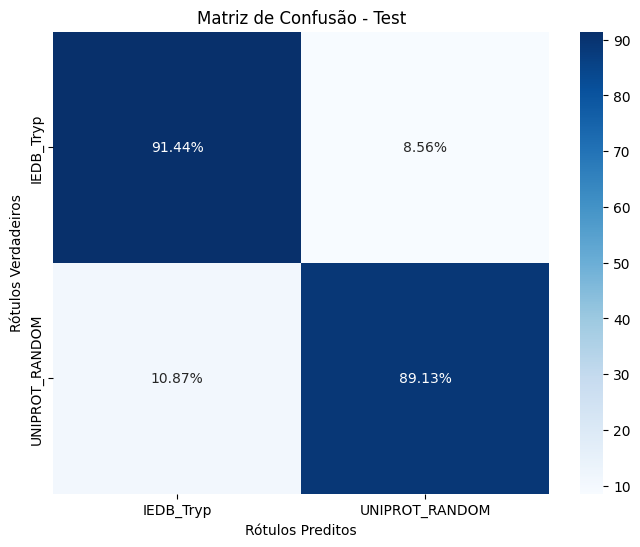

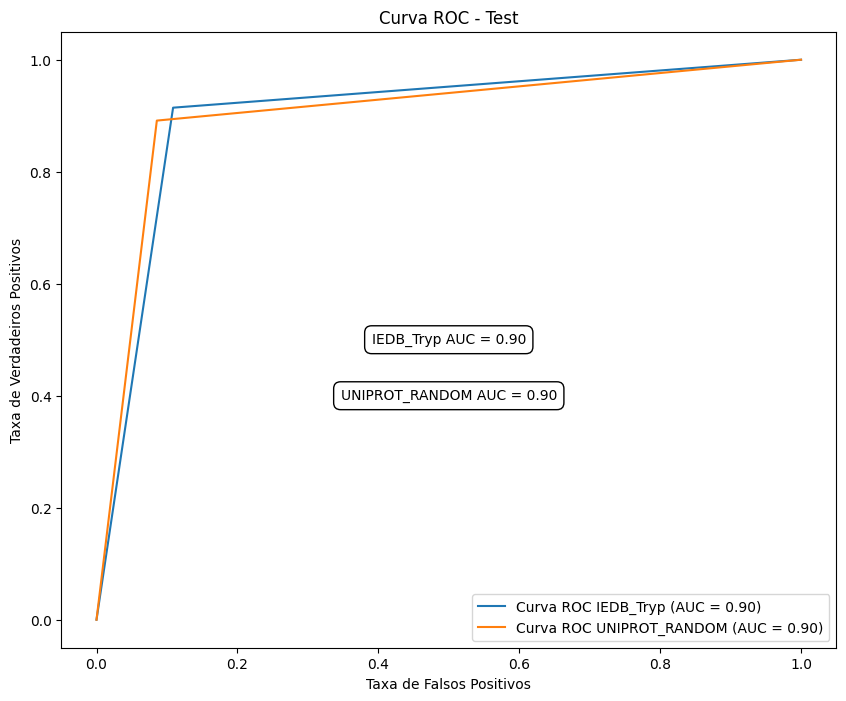


### Métricas para Training ###
Acurácia: 1.0
Recall para 'IEDB_Tryp': 1.0
Recall para 'UNIPROT_RANDOM': 1.0
F1-Score: 1.0
Precisão: 1.0
AUC: 1.0
MCC: 1.0


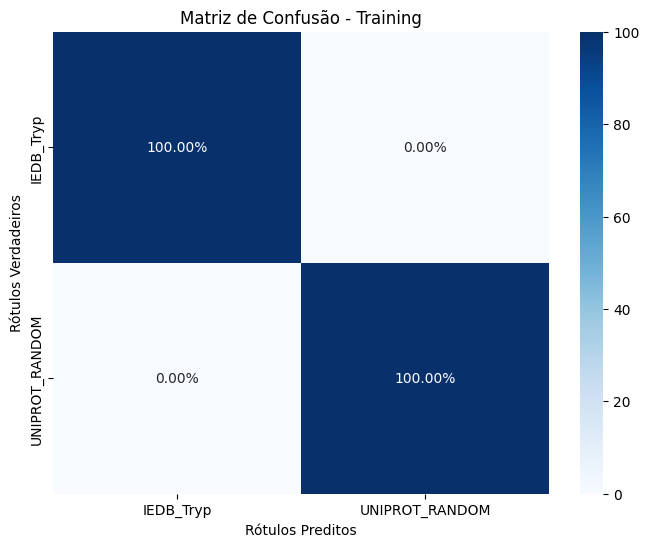

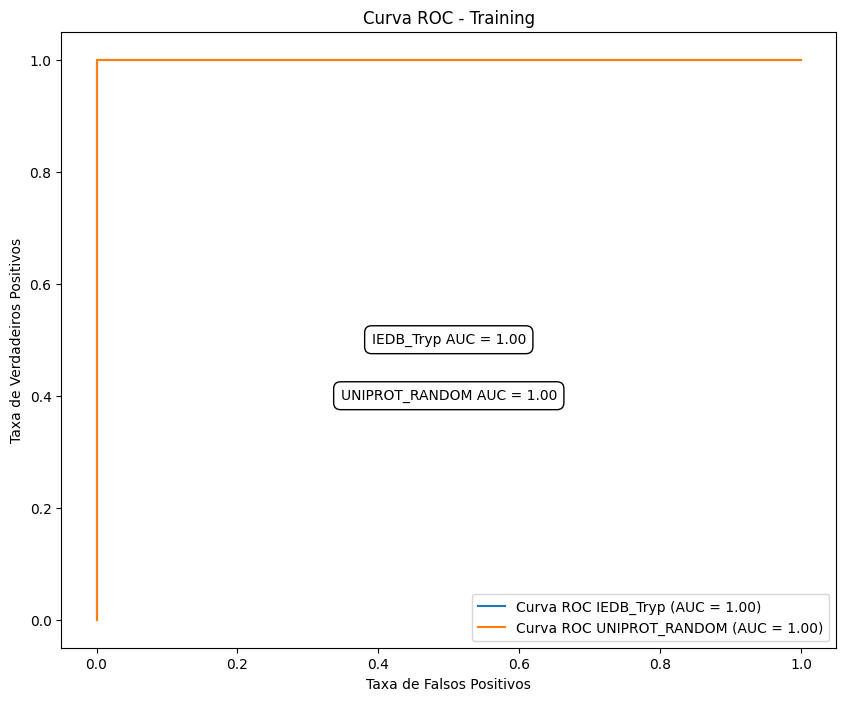

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

class_names = ['IEDB_Tryp', 'UNIPROT_RANDOM']
feature_names = ["Starting_Position", "Ending_Position", "Bepipred3", "Emini", "Kolaskar", "ChouFosman", "KarplusSchulz", "Parker", "MW", "IP", "Hydropathy"]

class DecisionTree:
    def __init__(self):
        self.model = None

    def train(self, X_train, y_train, height):
        self.model = DecisionTreeClassifier(criterion='entropy', max_depth=height, random_state=0)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        if self.model is None:
            raise Exception("Model not trained yet. Please train the model first.")
        return self.model.predict(X_test)

    def predict_proba(self, X_test):
        if self.model is None:
            raise Exception("Model not trained yet. Please train the model first.")
        return self.model.predict_proba(X_test)

    def plot_feature_importance(self, feature_names):
        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1]

        print("Feature importance")
        for i in indices:
            print(f"{feature_names[i]}: {importances[i]:.2%}")

        colors = plt.cm.viridis(np.linspace(0, 1, len(importances)))

        plt.figure(figsize=(16, 10))
        bars = plt.barh(range(len(importances)), importances[indices], color=colors, align="center")
        plt.yticks(range(len(importances)), np.array(feature_names)[indices])
        plt.xlabel("Importance")
        plt.title("Feature importance")

        for bar in bars:
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2%}', ha='left', va='center')

        plt.show()

def evaluate(y_true, y_pred, y_prob, class_names, label_encoder, dataset_type):
    print(f"\n### Métricas para {dataset_type} ###")

    accuracy = accuracy_score(y_true, y_pred)
    print("Acurácia:", accuracy)

    recall_iedb = recall_score(y_true, y_pred, pos_label=label_encoder.transform(['IEDB_Tryp'])[0])
    print("Recall para 'IEDB_Tryp':", recall_iedb)
    recall_uniprot = recall_score(y_true, y_pred, pos_label=label_encoder.transform(['UNIPROT_RANDOM'])[0])
    print("Recall para 'UNIPROT_RANDOM':", recall_uniprot)

    f1 = f1_score(y_true, y_pred, average="weighted")
    print("F1-Score:", f1)

    precision = precision_score(y_true, y_pred, average="weighted")
    print("Precisão:", precision)

    auc = roc_auc_score(y_true, y_pred, average="weighted", multi_class="ovr")
    print("AUC:", auc)

    mcc = matthews_corrcoef(y_true, y_pred)
    print("MCC:", mcc)

    labels = label_encoder.transform(['IEDB_Tryp', 'UNIPROT_RANDOM'])
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm_percent, annot=True, cmap="Blues", fmt=".2f",
                     xticklabels=['IEDB_Tryp', 'UNIPROT_RANDOM'],
                     yticklabels=['IEDB_Tryp', 'UNIPROT_RANDOM'])

    for t in ax.texts:
        t.set_text(f'{float(t.get_text()):.2f}%')

    plt.xlabel("Rótulos Preditos")
    plt.ylabel("Rótulos Verdadeiros")
    plt.title(f"Matriz de Confusão - {dataset_type}")
    plt.show()

    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true == i, y_prob[:, i])
        auc_score = roc_auc_score(y_true == i, y_prob[:, i])
        plt.plot(fpr, tpr, label=f'Curva ROC {class_name} (AUC = {auc_score:.2f})')

        plt.text(0.5, 0.5 - 0.1 * i, f'{class_name} AUC = {auc_score:.2f}',
                 horizontalalignment='center', verticalalignment='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curva ROC - {dataset_type}')
    plt.legend(loc='lower right')
    plt.show()

def load_dataset(file_path):
    df = pd.read_csv(file_path, sep="\t", dtype=str)  # Ler como string para tratar os números

    print(f"This dataset has {df.shape[0]} rows and {df.shape[1]} columns.\n")

    df = df.drop(["Id", "Name"], axis=1)
    target_column = "Group"

    # Tratamento de números formatados
    for col in df.columns:
        df[col] = df[col].str.replace('.', '', regex=False)  # Remover pontos
        df[col] = pd.to_numeric(df[col], errors='ignore')  # Converter para número quando possível

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

    print("### Proporção de Classes em Treino ###")
    class_counts_train = pd.Series(y_train).value_counts(normalize=True)
    print(f"Porcentagem Classe 'IEDB_Tryp': {class_counts_train.get(label_encoder.transform(['IEDB_Tryp'])[0], 0) * 100}%")
    print(f"Porcentagem Classe 'UNIPROT_RANDOM': {class_counts_train.get(label_encoder.transform(['UNIPROT_RANDOM'])[0], 0) * 100}%\n")

    print("### Proporção de Classes em Teste ###")
    class_counts_test = pd.Series(y_test).value_counts(normalize=True)
    print(f"Porcentagem Classe 'IEDB_Tryp': {class_counts_test.get(label_encoder.transform(['IEDB_Tryp'])[0], 0) * 100}%")
    print(f"Porcentagem Classe 'UNIPROT_RANDOM': {class_counts_test.get(label_encoder.transform(['UNIPROT_RANDOM'])[0], 0) * 100}%\n")

    return X_train, X_test, y_train, y_test, label_encoder

if __name__ == "__main__":
    file_path = "tryp_linear_bcell - dataset.tsv"
    X_train, X_test, y_train, y_test, label_encoder = load_dataset(file_path)

    model = DecisionTree()
    model.train(X_train, y_train, 20)

    model.plot_feature_importance(feature_names)

    y_pred_test = model.predict(X_test)
    y_prob_test = model.predict_proba(X_test)
    evaluate(y_test, y_pred_test, y_prob_test, class_names, label_encoder, "Test")

    y_pred_train = model.predict(X_train)
    y_prob_train = model.predict_proba(X_train)
    evaluate(y_train, y_pred_train, y_prob_train, class_names, label_encoder, "Training")


In [ ]:
!pip install graphviz

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Exemplo de dados fictícios (substitua pelos seus)
X_train = [[0, 0], [1, 1]]
y_train = [0, 1]

# Criando e treinando o modelo corretamente
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Exportando a árvore de decisão
dot_data = export_graphviz(model, out_file=None, feature_names=["feature1", "feature2"],
                           class_names=["class0", "class1"], filled=True, rounded=True, special_characters=True)

# Gerando e visualizando a árvore
graph = graphviz.Source(dot_data, format="png")
graph.render("decision_tree")
graph.view()


'decision_tree.png'